In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import cv2

from PIL import Image
from tqdm import tqdm

# set the random seed
seed = 314
tf.random.set_seed(seed)
np.random.seed(seed)



In [2]:
class_names = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['C:/Users/mehdi/Downloads/YOGA/YOGA/content/cleaned/DATASET/TRAIN', 'C:/Users/mehdi/Downloads/YOGA/YOGA/content/cleaned/DATASET/TEST']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Users/mehdi/Downloads/YOGA/YOGA/content/cleaned/DATASET/TRAIN


100%|██████████| 250/250 [00:13<00:00, 18.40it/s]


Loading C:/Users/mehdi/Downloads/YOGA/YOGA/content/cleaned/DATASET/TEST


100%|██████████| 109/109 [00:07<00:00, 15.20it/s]


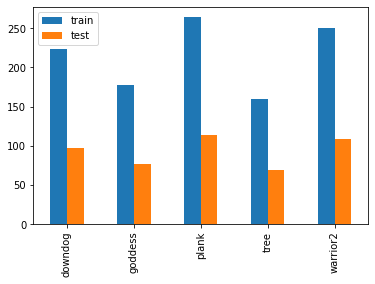

In [5]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

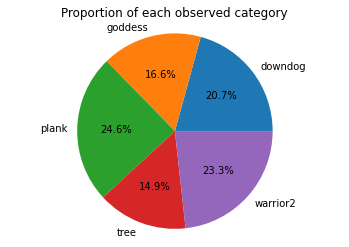

In [6]:
import matplotlib.pyplot as plt
import pandas as pd


plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [7]:
#Normalisation 
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [8]:
train_labels=tf.keras.utils.to_categorical(train_labels)
test_labels=tf.keras.utils.to_categorical(test_labels)


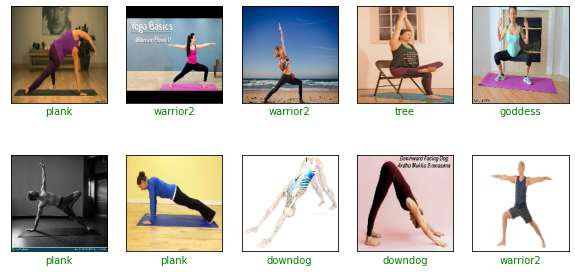

In [9]:
#affichage des images au hazard
import matplotlib.pyplot as plt

def show_random_examples(x,y,p):
    indices=np.random.choice(range(x.shape[0]),10,replace=True)
    x=x[indices]
    y=y[indices]
    p=p[indices]
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col='green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])],color=col)
    plt.show()
show_random_examples(train_images,train_labels,train_labels)

# Start Tuning

## Tuning on Parameters with RANDOMSEARCH

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband




# Define the model-building function
def build_model(hp):
    # Define the model architecture
    model = keras.Sequential()

    # Add the convolutional layers
    model.add(layers.Conv2D(hp.Int('conv1_filters', min_value=32, max_value=64, step=16), 
                            kernel_size=3, activation='relu', padding='same', input_shape=(150, 150, 3)))
    model.add(layers.AveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(hp.Int('conv2_filters', min_value=32, max_value=64, step=16), 
                            kernel_size=3, activation='relu', padding='same'))
    model.add(layers.AveragePooling2D())
    model.add(layers.Conv2D(hp.Int('conv3_filters', min_value=64, max_value=128, step=32), 
                            kernel_size=3, activation='relu', padding='same'))
    model.add(layers.AveragePooling2D())
    model.add(layers.Conv2D(hp.Int('conv4_filters', min_value=64, max_value=128, step=32), 
                            kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(hp.Int('conv5_filters', min_value=128, max_value=256, step=64), 
                            kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())

    # Add the flatten layer before the dense layers
    model.add(layers.Flatten())

    # Add the dense layers
    model.add(layers.Dense(hp.Int('dense_units', min_value=256, max_value=1024, step=256), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Add the output layer with softmax activation for multi-class classification
    model.add(layers.Dense(5, activation='softmax'))

    # Compile the model with categorical cross-entropy loss and the Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

    return model


tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='models',
    project_name='my_model')



# Search for the best hyperparameters
tuner.search(train_images, train_labels, epochs=15, batch_size=128, validation_data=(test_images, test_labels))

# Print the summary of the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(test_images, test_labels)
print(f"Test accuracy of the best model: {accuracy}")


Trial 30 Complete [00h 04m 46s]
val_accuracy: 0.8347639441490173

Best val_accuracy So Far: 0.8690987229347229
Total elapsed time: 00h 51m 49s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 75, 75, 32)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 average_pooling2d_1 (Averag  (None, 37, 37, 32)       0         
 ePooling2D)                                                     
                                                        

# Tuning on the number of layers

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the function to create the model
def create_model(num_layers):
    # Create a sequential model
    model = keras.Sequential()

    # Add the input layer
    model.add(layers.Input(shape=(150, 150, 3)))

    # Add the convolutional layers
    for i in range(num_layers):
        model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'))
        model.add(layers.AveragePooling2D())

    model.add(layers.BatchNormalization())

    # Add the flatten layer before the dense layers
    model.add(layers.Flatten())

    # Add the dense layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.1))

    # Add the output layer with softmax activation for multi-class classification
    model.add(layers.Dense(5, activation='softmax'))

    return model

# Define the number of layers to explore
num_layers_to_try = [1, 2, 3, 4, 5]


# Iterate over the number of layers to explore and train models with each number of layers
for num_layers in num_layers_to_try:
    # Create the model
    model = create_model(num_layers)

    # Compile the model with categorical cross-entropy loss and the Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

    # Train the model
    history = model.fit(train_images, train_labels, epochs=15, batch_size=128, validation_data=(test_images, test_labels), callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy')
    ])

    # Evaluate the model on the test data
    loss, accuracy = model.evaluate(test_images, test_labels)
    print(f"Number of layers: {num_layers}, Test accuracy: {accuracy}")


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the model architecture
model = tf.keras.Sequential()

# Add the convolutional layers
model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(layers.AveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(layers.AveragePooling2D())
model.add(layers.Conv2D(96, kernel_size=3, activation='relu', padding='same'))
model.add(layers.AveragePooling2D())
model.add(layers.Conv2D(96, kernel_size=3, activation='relu', padding='same'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(layers.MaxPooling2D())

# Add the flatten layer before the dense layers
model.add(layers.Flatten())

# Add the dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

# Add the output layer with softmax activation for multi-class classification
model.add(layers.Dense(5, activation='softmax'))

# Compile the model with categorical cross-entropy loss and the Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

# Print the model summary
model.summary()


<h1>TRAINING USING HYPERBAND </h1>

In [21]:
model = keras.Sequential()

# Add the convolutional layers
model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(layers.AveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(layers.AveragePooling2D())
model.add(layers.Conv2D(96, kernel_size=3, activation='relu', padding='same'))
model.add(layers.AveragePooling2D())
model.add(layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(192, kernel_size=3, activation='relu', padding='same'))
model.add(layers.MaxPooling2D())

# Add the flatten layer before the dense layers
model.add(layers.Flatten())

# Add the dense layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

# Add the output layer with softmax activation for multi-class classification
model.add(layers.Dense(5, activation='softmax'))

# Compile the model with categorical cross-entropy loss and the Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 average_pooling2d_3 (Averag  (None, 75, 75, 32)       0         
 ePooling2D)                                                     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 average_pooling2d_4 (Averag  (None, 37, 37, 32)       0         
 ePooling2D)                                                     
                                                      

In [22]:
history = model.fit(train_images, train_labels, epochs=15,batch_size=128, validation_data=(test_images, test_labels), callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4),
    tf.keras.callbacks.ModelCheckpoint(
    'models/model_{val_accuracy:.3f}.h5',save_best_only=True,save_weights_only=False,monitor='val_accuracy')
])


Epoch 1/15
9/9 [==============================] - 13s 1s/step - loss: 1.6419 - accuracy: 0.2735 - val_loss: 1.5940 - val_accuracy: 0.2833
Epoch 2/15
9/9 [==============================] - 11s 1s/step - loss: 1.4597 - accuracy: 0.3981 - val_loss: 1.5892 - val_accuracy: 0.2253
Epoch 3/15
9/9 [==============================] - 11s 1s/step - loss: 1.2742 - accuracy: 0.5135 - val_loss: 1.5199 - val_accuracy: 0.4227
Epoch 4/15
9/9 [==============================] - 11s 1s/step - loss: 1.1366 - accuracy: 0.5544 - val_loss: 1.3589 - val_accuracy: 0.5494
Epoch 5/15
9/9 [==============================] - 12s 1s/step - loss: 1.0010 - accuracy: 0.6186 - val_loss: 1.3536 - val_accuracy: 0.6867
Epoch 6/15
9/9 [==============================] - 11s 1s/step - loss: 0.8458 - accuracy: 0.6930 - val_loss: 1.3144 - val_accuracy: 0.6330
Epoch 7/15
9/9 [==============================] - 11s 1s/step - loss: 0.6846 - accuracy: 0.7479 - val_loss: 1.2383 - val_accuracy: 0.6395
Epoch 8/15
9/9 [==================

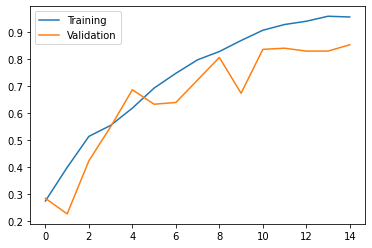

In [23]:
accs=history.history['accuracy']
val_accs=history.history['val_accuracy']
plt.plot(range(len(accs)),accs,label='Training')
plt.plot(range(len(accs)),val_accs,label='Validation')
plt.legend()
plt.show()



In [11]:
model=tf.keras.models.load_model('models/model_0.854.h5')

15/15 [==============================] - 4s 222ms/step


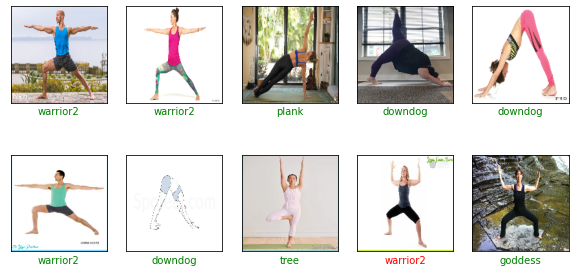

In [12]:
preds=model.predict(test_images)
show_random_examples(test_images,test_labels,preds)

In [13]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_images, test_labels)

# Get the predicted class probabilities for the test set
predicted_probabilities = model.predict(test_images)

# Get the predicted class labels by taking the index of the highest probability
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Get the true class labels by taking the index of the highest value
true_labels = np.argmax(test_labels, axis=1)

# Compute the number of true and false predictions
num_true_predictions = np.sum(predicted_labels == true_labels)
num_false_predictions = len(true_labels) - num_true_predictions

# Print the number of true and false predictions
print(f"Number of true predictions: {num_true_predictions}")
print(f"Number of false predictions: {num_false_predictions}")


15/15 [==============================] - 3s 208ms/step
Number of true predictions: 398
Number of false predictions: 68


In [ ]:
import cv2

# Load the image
image = cv2.imread('C:/Users/MSi/Desktop/lab_dl/screenshot.png')
image = cv2.resize(image, (150, 150))
image = np.expand_dims(image, axis=0)
image = image / 255.0

# Make a prediction
prediction = model.predict(image)

# Print the predicted class
predicted_class = np.argmax(prediction)
print('Predicted class:', predicted_class)
print(class_names[predicted_class])


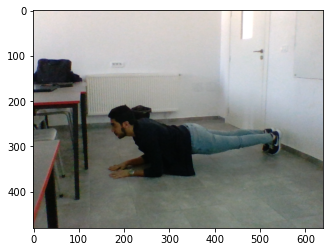

In [19]:
import cv2
import time
import matplotlib.image as mpimg

# Open the default camera
cap = cv2.VideoCapture(0)

# Set the timer for 7 seconds
timer_duration = 10

# Set the start time
start_time = time.time()

# Loop until timer is up
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

    # If the elapsed time is greater than the timer duration, take a screenshot and break out of the loop
    if elapsed_time >= timer_duration:
        filename = 'screenshot.png'
        cv2.imwrite(filename, frame)
        break

    # Display the countdown number on the frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (150, 150)
    fontScale = 2
    fontColor = (255, 255, 255)
    lineType = 2
    countdown_number = str(int(timer_duration - elapsed_time))
    cv2.putText(frame, countdown_number, bottomLeftCornerOfText, font, fontScale, fontColor, lineType)

    # Display the resulting frame
    cv2.imshow('frame', frame)

    # Wait for 1 second before displaying the next frame
    cv2.waitKey(1000)

# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()
img_path = "screenshot.png"

# read the image using matplotlib's imread() function
img = mpimg.imread(img_path)

# display the image using matplotlib's imshow() function
plt.imshow(img)
plt.show()

In [20]:
import cv2

# Load the image
image = cv2.imread('C:/Users/mehdi/screenshot.png')
image = cv2.resize(image, (150, 150))
image = np.expand_dims(image, axis=0)
image = image / 255.0

# Make a prediction
prediction = model.predict(image)

# Print the predicted class
predicted_class = np.argmax(prediction)
print('Predicted class:', predicted_class)
print(class_names[predicted_class])



1/1 [==============================] - 0s 78ms/step
Predicted class: 2
plank
